In [283]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import joblib

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention
from tensorflow.keras.optimizers import Adam
from typing import Dict, List, Tuple, Union
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

In [284]:
olist_df = pd.read_csv(r'/content/drive/MyDrive/E-Commerce-Chatbot/Data/df_sampled_olist.csv')
olist_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,geolocation_city,geolocation_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category,comparator_price
0,5eb5db738b8f5ebe2a07fe4fd5af2b8c,8fbefa23ae0c37b2b4ca94dd96abdb78,21230,rio de janeiro,RJ,26a44b28ac942b09a771479c880882d9,delivered,2017-07-30 19:23:33,2017-07-30 19:35:18,2017-08-02 19:24:00,...,rio de janeiro,RJ,ceb5e7e8598d5c949e346aca45a4c8e0,5.0,NaN,Ótimo,2017-08-10 00:00:00,2017-08-10 23:42:46,Home & Garden,47.278362
1,2bd62951b26a453e99cea4aaf432ed45,39518dab7aa8a79da80322d53bf504d4,4005,sao paulo,SP,7a93502a455e1399090b442409cf516c,delivered,2018-07-27 14:58:55,2018-07-27 15:31:16,2018-08-01 18:13:00,...,sao paulo,SP,be9d505f73a72ca9af17ed02926d8d7b,3.0,NaN,NaN,2018-08-07 00:00:00,2018-08-07 22:25:09,Furniture,90.199163
2,551adb1ab4dd9254a79d487f163c9629,305af21f2178486da285dd0082ae5240,8371,sao paulo,SP,62899f7b8e4122204fc3d26d8d2c3737,delivered,2017-07-19 11:34:45,2017-07-20 11:43:36,2017-07-20 17:54:52,...,sao paulo,SP,8848a9dafb4a3f6eea027ee2322ff6d4,5.0,NaN,NaN,2017-08-05 00:00:00,2017-08-08 13:47:58,Home & Garden,110.554609
3,b71cd39228d8554a93375e867f35e724,12613f1b2693e38c011a5c20a9e2f2a8,38610,unai,MG,9de65156d923c62015d982bd3f6ade9b,delivered,2018-02-28 09:42:13,2018-03-03 02:49:38,2018-03-08 18:19:45,...,unai,MG,60b32cb1df5164832f4a283b32e6dcc5,1.0,NaN,Realizei a compra de um Toner Original CE320A ...,2018-03-23 00:00:00,2018-03-28 14:41:51,Electronics,212.687803
4,d4ba90ce0c49bffcd1b221f4bd2e9741,08a151ec3a5cbe140edd1fa285f6c853,25550,sao joao de meriti,RJ,284f45ebbf2b9dae5ad6699417798e08,delivered,2017-07-01 15:09:06,2017-07-01 15:24:00,2017-07-06 15:45:57,...,sao joao de meriti,RJ,78b6a2a48db20e7d70c5ad2ef90c3024,5.0,NaN,NaN,2017-07-19 00:00:00,2017-07-20 02:04:54,Home & Garden,36.167473


In [285]:
olist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    20000 non-null  object 
 1   customer_unique_id             20000 non-null  object 
 2   customer_zip_code_prefix       20000 non-null  int64  
 3   customer_city                  20000 non-null  object 
 4   customer_state                 20000 non-null  object 
 5   order_id                       20000 non-null  object 
 6   order_status                   20000 non-null  object 
 7   order_purchase_timestamp       20000 non-null  object 
 8   order_approved_at              19997 non-null  object 
 9   order_delivered_carrier_date   19794 non-null  object 
 10  order_delivered_customer_date  19616 non-null  object 
 11  order_estimated_delivery_date  20000 non-null  object 
 12  payment_sequential             20000 non-null 

In [286]:
class TimeSeriesPreprocessor:
    def __init__(self, dataframe):
        self.dataframe = dataframe.copy()
        self.daily_metrics = None

    def preprocess(self):
        # Convert to datetime
        self.dataframe['order_purchase_timestamp'] = pd.to_datetime(self.dataframe['order_purchase_timestamp'])

        # Extract date features
        self.dataframe['year'] = self.dataframe['order_purchase_timestamp'].dt.year
        self.dataframe['month'] = self.dataframe['order_purchase_timestamp'].dt.month
        self.dataframe['day'] = self.dataframe['order_purchase_timestamp'].dt.day
        self.dataframe['day_of_week'] = self.dataframe['order_purchase_timestamp'].dt.dayofweek
        self.dataframe['is_weekend'] = self.dataframe['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

        # Set index and resample daily metrics
        self.dataframe.set_index('order_purchase_timestamp', inplace=True)
        self.daily_metrics = self.dataframe.resample('D').agg({
            'order_id': 'count',
            'payment_value': 'sum',
            'price': 'mean'
        })
        self.daily_metrics.rename(columns={'order_id': 'daily_orders'}, inplace=True)

        # Handle missing values
        self.daily_metrics.ffill(inplace=True)

    def create_sequences(self, seq_length):
        # Scale data
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(self.daily_metrics)

        # Create sequences
        X, y = [], []
        for i in range(len(scaled_data) - seq_length):
            X.append(scaled_data[i:i + seq_length])
            y.append(scaled_data[i + seq_length])
        return np.array(X), np.array(y), scaler

In [287]:
class LSTMModel:
    def __init__(self, seq_length):
        self.seq_length = seq_length
        self.model = None
        self.scaler = None

    def build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        lstm_out = LSTM(64, return_sequences=True)(inputs)
        attention = Attention()([lstm_out, lstm_out])
        lstm_out = LSTM(32)(attention)
        outputs = Dense(3)(lstm_out)
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer='adam', loss='mean_squared_error')

        # Compile model
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    def train(self, X_train, y_train, epochs=50, batch_size=32):
        # Train model
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    def predict(self, X_test):
        # Make predictions
        return self.model.predict(X_test)

    def evaluate(self, y_test, predictions):
        # Inverse scaling and calculate metrics
        y_test = self.scaler.inverse_transform(y_test)
        predictions = self.scaler.inverse_transform(predictions)

        # Extract columns for each metric
        y_test_orders = y_test[:, 0]
        y_test_payment_value = y_test[:, 1]
        y_test_price = y_test[:, 2]

        pred_orders = predictions[:, 0]
        pred_payment_value = predictions[:, 1]
        pred_price = predictions[:, 2]

        # Calculate RMSE and MAE for each metric
        rmse_orders = np.sqrt(mean_squared_error(y_test_orders, pred_orders))
        mae_orders = mean_absolute_error(y_test_orders, pred_orders)

        rmse_payment_value = np.sqrt(mean_squared_error(y_test_payment_value, pred_payment_value))
        mae_payment_value = mean_absolute_error(y_test_payment_value, pred_payment_value)

        rmse_price = np.sqrt(mean_squared_error(y_test_price, pred_price))
        mae_price = mean_absolute_error(y_test_price, pred_price)

        evaluation_results = pd.DataFrame({
            'Metric': ['daily_orders', 'payment_value', 'price'],
            'RMSE': [rmse_orders, rmse_payment_value, rmse_price],
            'MAE': [mae_orders, mae_payment_value, mae_price]
        })

        return evaluation_results

    def save_model(self, model_path, scaler_path):
        # Save the model
        self.model.save(model_path)
        # Save the scaler
        joblib.dump(self.scaler, scaler_path)

        return model_path, scaler_path

    def load_model(self, model_path, scaler_path):
        # Load the model
        self.model = load_model(model_path)
        # Load the scaler
        self.scaler = joblib.load(scaler_path)

In [288]:
def plot_results(y_test, predictions, metric_names):
    # Inverse scaling for plotting
    y_test = y_test.reshape(-1, len(metric_names))
    predictions = predictions.reshape(-1, len(metric_names))

    # Extract metrics for plotting
    y_test_orders = y_test[:, 0]
    y_test_payment_value = y_test[:, 1]
    y_test_price = y_test[:, 2]

    pred_orders = predictions[:, 0]
    pred_payment_value = predictions[:, 1]
    pred_price = predictions[:, 2]

    # Create subplots
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

    # Plot for daily_orders
    axs[0].plot(y_test_orders, label='Actual daily_orders', color='blue')
    axs[0].plot(pred_orders, label='Predicted daily_orders', color='orange')
    axs[0].set_title('Daily Orders')
    axs[0].set_ylabel('Count')
    axs[0].legend()

    # Plot for payment_value
    axs[1].plot(y_test_payment_value, label='Actual payment_value', color='blue')
    axs[1].plot(pred_payment_value, label='Predicted payment_value', color='orange')
    axs[1].set_title('Payment Value')
    axs[1].set_ylabel('Value')
    axs[1].legend()

    # Plot for price
    axs[2].plot(y_test_price, label='Actual price', color='blue')
    axs[2].plot(pred_price, label='Predicted price', color='orange')
    axs[2].set_title('Price')
    axs[2].set_ylabel('Price')
    axs[2].legend()

    plt.tight_layout()
    plt.show()


def run_time_series_analysis(olist_df, seq_length=7, epochs=50, batch_size=32,
                             model_path='./artifacts/lstm_model.h5', scaler_path='./artifacts/scaler.pkl'):
    # Initialize and preprocess the data
    preprocessor = TimeSeriesPreprocessor(olist_df)
    preprocessor.preprocess()

    # Create sequences
    X, y, scaler = preprocessor.create_sequences(seq_length)

    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train LSTM model
    lstm_model = LSTMModel(seq_length)
    lstm_model.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    lstm_model.train(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # Save the model and scaler
    lstm_model.save_model(model_path, scaler_path)

    # Load the model and scaler (if needed)
    lstm_model.load_model(model_path, scaler_path)

    # Make predictions
    predictions = lstm_model.predict(X_test)

    # Set scaler for inverse transformation
    lstm_model.scaler = scaler

    # Evaluate model and return results as DataFrame
    evaluation_results = lstm_model.evaluate(y_test, predictions)

    # Plot results
    plot_results(y_test, predictions, ['daily_orders', 'payment_value', 'price'])

    return evaluation_results

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0382
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0065
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0064
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0069
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0083
Epoch 16/50

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


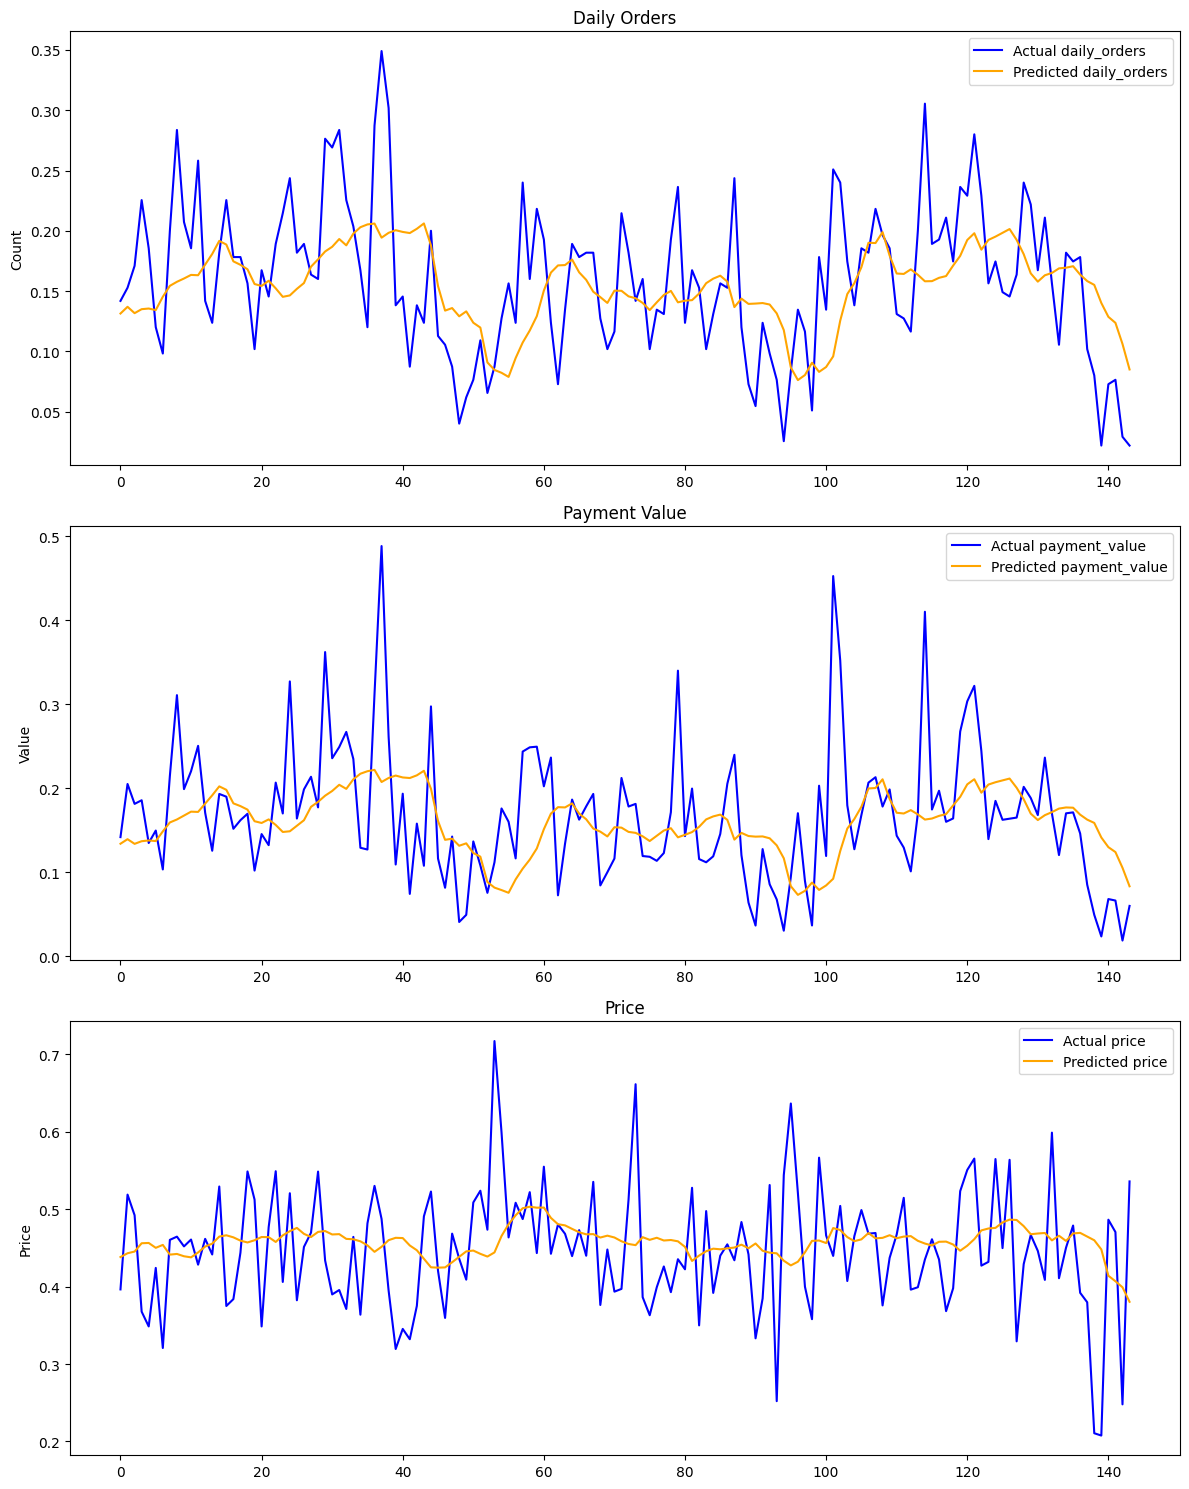

In [289]:
results_df = run_time_series_analysis(olist_df)

In [290]:
results_df

,Metric,RMSE,MAE
0,daily_orders,15.814390,12.713063
1,payment_value,2820.214457,2012.299777
2,price,13.506541,10.470247
